# Исследование объявлений о продаже квартир

  В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

**Задача исследования:** ознакомиться с аналитикой рынка недвижимости и выяснить, что влияет на конечную стоимость квартиры. Установленные параметры позволят построить автоматизированную систему, отслеживающую аномалии и мошеннические действия.


По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание данных:**
* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area`  — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — общая площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

In [3]:
pd.set_option('display.max_columns', 50)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
old_shape=df.shape[0] #чтобы потом сравнить количество удаленных строк
print(old_shape)

23699


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

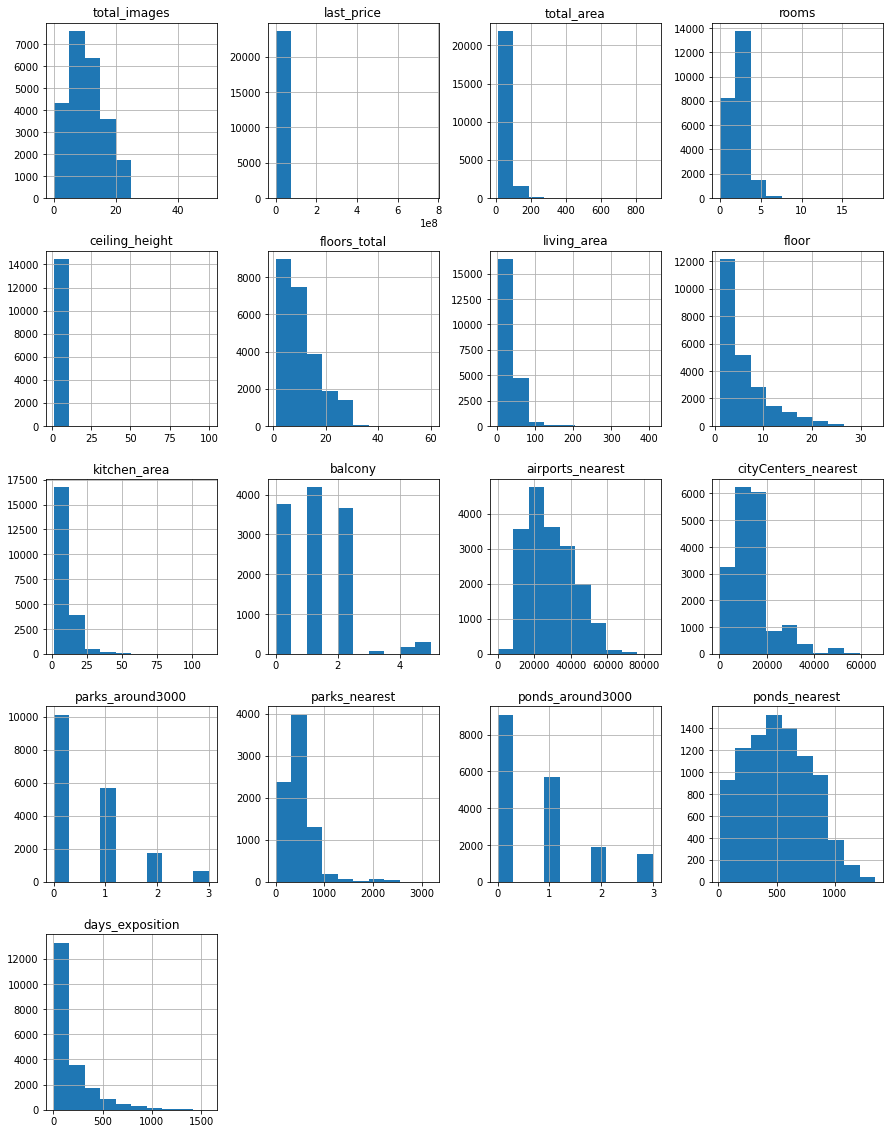

In [6]:
df.hist(figsize=(15, 20));



**Выводы:**

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения. 
   
В `days_exposition` и `balcony` тип данных должен быть int, т.к. количество балконов и дней - целое значение.

В `first_day_exposition` тип данных должен быть datetime.

А в `is_apartment` должен быть тип bool.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Предобработка данных

#### Пропуски значений

Выведем количество пропущенных значений для каждого столбца. 

In [7]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

* В `balcony` не указано число балконов, скорее всего, в этих квартирах их нет. Заменим эти пропуски на 0.

In [8]:
df['balcony'] = df['balcony'].fillna(0)

* В `is_apartment` много пропусков. Возможно, в ряде случаев, заполнялось только тогда, когда это были апартаменты, а в противном случае просто оставляли пункт не заполненным. Заменим пропущенные значения на False.

In [9]:
df['is_apartment'] = df['is_apartment'].fillna(False)

* А в  `living_area` как раз заполним пропуски медианным значением по квартирам,сгруппированным по количеству комнат.

In [10]:
median_living_area = df.groupby('rooms')['living_area'].transform('median')
df['living_area'] = df['living_area'].fillna(median_living_area)

 * В `kitchen_area` пропуски площади кухни в студиях заменим на 0, а в остальных случаях на среднюю долю площади кухни к общей площади квартиры. Так как в данном случае среднее значение практически не отличается от медианного, можем взять любое.

In [11]:
df.loc[(df['studio']==True)&(df['kitchen_area'].isna()==True),'kitchen_area']=0 #пропуски площади кухни в студиях заменим на 0

df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*(df['kitchen_area'].mean()/df['total_area'].mean()))

Проверим количество пропусков еще раз. В `ceiling_height` осталось много пропусков.Мы их заполним позже(средним или медианой), когда будем исправлять аномальные значения. Здесь их не мало. В оставшихся столбцах заполнение пропусков не представляется возможным. Но их наличие  не повлияет на картину исследования.

In [12]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Изменение типов данных

 Как уже ранее заметили,
 
В `days_exposition` и `balcony`  тип данных должен быть int, т.к. количество балконов и дней - целое значение.

В `first_day_exposition` тип данных должен быть datetime.

А в `is_apartment` должен быть тип bool.

И для удобства восприятия тип данных в `last_price` изменим тоже на int.

In [13]:

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')

convert_dict = {'balcony': int,
                'last_price': int,
                'is_apartment': bool
                }
df = df.astype(convert_dict)




Проверим еще раз типы данных:
                

In [14]:
df.dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

#### Устранение дубликатов

In [15]:
print(df.duplicated().sum())
print(df['locality_name'].value_counts())
df['locality_name'].sort_values().unique()

0
Санкт-Петербург                                      15721
посёлок Мурино                                         522
посёлок Шушары                                         440
Всеволожск                                             398
Пушкин                                                 369
                                                     ...  
деревня Новолисино                                       1
посёлок Петро-Славянка                                   1
деревня Хязельки                                         1
садовое товарищество Новая Ропша                         1
посёлок при железнодорожной станции Приветнинское        1
Name: locality_name, Length: 364, dtype: int64


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

   При проверке дубликатов, явных дубликатов выявлено не было, но есть неявные: 'поселок' и 'посёлок','городской поселок' и 'поселок городского типа','поселок при железнодорожной станции' и 'поселок станции', 'коттеджный поселок' вместо 'поселок')

In [16]:
df['locality_name'] = df['locality_name'].str.replace('посёлок', 'поселок')
df['locality_name'] = df['locality_name'].str.replace('городской поселок','поселок городского типа') 
df['locality_name'] = df['locality_name'].str.replace('поселок при железнодорожной станции','поселок станции')
df['locality_name'] = df['locality_name'].str.replace('коттеджный поселок','поселок')


In [17]:
df['locality_name'].value_counts()

Санкт-Петербург                     15721
поселок Мурино                        556
поселок Шушары                        440
Всеволожск                            398
Пушкин                                369
                                    ...  
поселок Гладкое                         1
поселок Высокоключевой                  1
поселок Севастьяново                    1
деревня Большой Сабск                   1
садовое товарищество Новая Ропша        1
Name: locality_name, Length: 320, dtype: int64

После исправления и проверки, уникальных значений стало на 44 меньше.

#### Устранение редких и выбивающихся значений (аномалии) во всех столбцах

Для выявления аномалий построим гистограммы для всех столбцов и отдельно в каждом методом describe() и графиками посмотрим нестандартные значения. Для этого создадим функцию.

In [18]:
def info_column(name_column):
    display(df.sort_values(by=name_column),df[name_column].describe())
    df[name_column].hist(figsize=(10,4),legend=True);
    plt.show()
    df.boxplot(column=name_column);                    

##### 'total_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19904,4,2400000,12.0,2017-07-19,1,2.55,5.0,10.0,2,False,False,False,2.087230,0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0
17961,3,1400000,13.0,2017-12-03,1,2.60,9.0,17.6,1,False,False,False,2.261166,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0
19546,3,1850000,13.0,2019-03-11,1,3.40,5.0,17.6,2,False,False,False,2.261166,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0
19807,0,3800000,13.0,2018-07-04,1,NaN,5.0,10.0,3,False,False,False,2.261166,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0
19558,2,1686000,13.2,2018-12-17,1,NaN,5.0,17.6,1,False,False,False,2.295953,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5358,20,65000000,590.0,2019-02-14,15,3.50,6.0,409.0,3,False,False,False,100.000000,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
15651,20,300000000,618.0,2017-12-18,7,3.40,7.0,258.0,5,False,False,False,70.000000,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
3117,19,140000000,631.0,2019-03-30,7,NaN,5.0,145.0,5,False,False,False,60.000000,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
12859,20,140000000,631.2,2019-04-09,7,3.90,4.0,322.3,4,False,False,False,19.500000,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN


count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

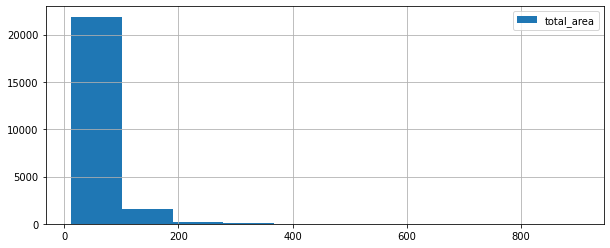

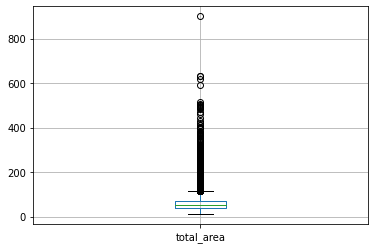

In [19]:
info_column('total_area');

При медиане 50, среднее - 60. Такая разница из-за большого разброса: от min 12 м² до max 900 м². И если минимальное вполне может быть студией, максимальный порог рассмотрим поближе.

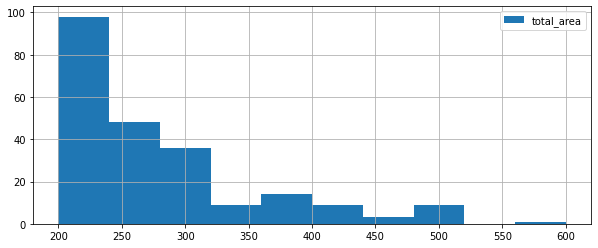

<AxesSubplot:>

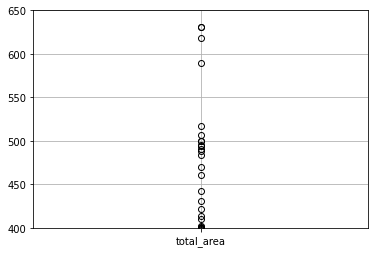

In [20]:
df['total_area'].hist(figsize=(10,4),legend=True,range=(200,600));
plt.show()
plt.ylim(400,650)
df.boxplot(column ='total_area')                     

Все квартиры площадью больше 400 м² очень похожи на аномалии и их не много. Удалим их.

In [21]:
display(df[df['total_area']>400]) #квартиры с площадью больше 400 м², которые будем удалять.
df=df[df['total_area']<=400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000,483.90,2017-10-04,7,3.20,6.0,312.500,4,False,False,False,26.400000,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
3117,19,140000000,631.00,2019-03-30,7,NaN,5.0,145.000,5,False,False,False,60.000000,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3676,12,28789000,441.98,2019-01-23,4,NaN,6.0,63.600,6,False,False,False,35.050000,0,Санкт-Петербург,20552.0,5181.0,0.0,NaN,0.0,NaN,NaN
4237,1,50000000,517.00,2017-10-14,7,NaN,4.0,332.000,3,False,False,False,22.000000,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000,590.00,2019-02-14,15,3.50,6.0,409.000,3,False,False,False,100.000000,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
5893,3,230000000,500.00,2017-05-31,6,NaN,7.0,123.900,7,False,False,False,40.000000,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
6221,8,34000000,470.30,2018-01-14,4,NaN,3.0,248.700,3,False,False,False,40.000000,0,Санкт-Петербург,43756.0,15459.0,1.0,852.0,3.0,122.0,179.0
6621,20,99000000,488.00,2017-04-09,5,2.95,20.0,216.000,17,False,False,False,50.000000,0,Санкт-Петербург,27641.0,4598.0,1.0,646.0,1.0,368.0,351.0
8018,20,84000000,507.00,2015-12-17,5,4.45,7.0,301.500,7,True,False,False,45.500000,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
9826,1,43185328,494.10,2017-05-12,1,2.85,12.0,17.600,3,False,False,False,85.941702,0,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0


##### 'living_area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13915,20,6350000,52.0,2018-02-06,2,3.0,6.0,2.0,2,False,False,False,9.0,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000,23.0,2018-01-01,0,NaN,24.0,2.0,22,False,True,False,0.0,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
3242,7,4440000,41.0,2017-07-02,1,NaN,17.0,3.0,17,False,False,False,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
23574,14,64990000,139.0,2015-11-24,3,3.0,8.0,3.0,8,False,False,False,16.0,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
17582,11,2680000,22.0,2018-08-11,0,NaN,25.0,5.0,8,False,True,False,0.0,2,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,10,65000000,364.0,2018-11-27,7,3.9,6.0,250.0,3,False,False,False,20.0,0,Санкт-Петербург,21988.0,3254.0,0.0,NaN,1.0,689.0,46.0
15701,12,83000000,293.6,2017-11-10,4,NaN,9.0,250.0,7,False,False,False,35.0,0,Санкт-Петербург,25593.0,5913.0,2.0,164.0,0.0,NaN,NaN
1085,16,75000000,323.0,2017-07-10,5,4.0,5.0,255.7,4,False,False,False,66.0,0,Санкт-Петербург,23713.0,594.0,3.0,398.0,2.0,515.0,259.0
19865,20,180000000,347.0,2015-01-21,8,3.9,6.0,260.0,3,False,False,False,45.0,0,Санкт-Петербург,23962.0,3794.0,2.0,537.0,3.0,501.0,834.0


count    23676.000000
mean        34.134320
std         20.570455
min          2.000000
25%         18.400000
50%         30.300000
75%         42.600000
max        264.500000
Name: living_area, dtype: float64

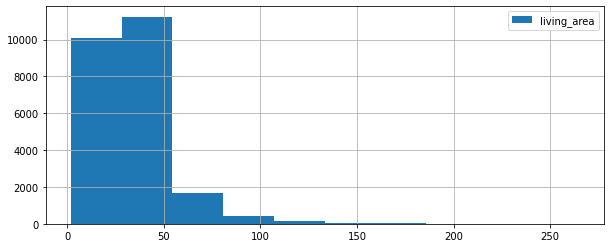

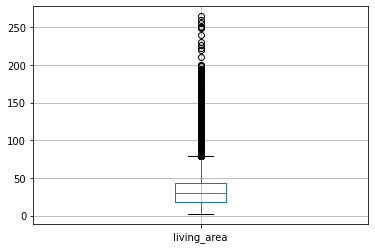

In [22]:
info_column('living_area');

Настораживает min жилая площадь = 2. в таблице таких значений несколько. Посмотрим на диаграмме рассеяния выбивающиеся значения. Так же при медиане 30, максимальное значение 264 это очень много, поэтому увеличим масштаб. 

<AxesSubplot:xlabel='living_area', ylabel='total_area'>

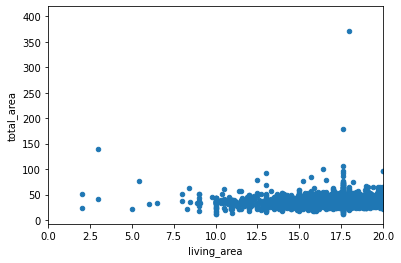

In [23]:
df.plot(x='living_area', y='total_area', kind='scatter',xlim = (0,20)) 

<AxesSubplot:xlabel='living_area', ylabel='total_area'>

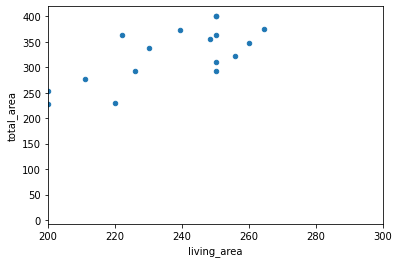

In [24]:
df.plot(x='living_area', y='total_area', kind='scatter',xlim = (200,300)) 

AxesSubplot(0.125,0.125;0.775x0.755)


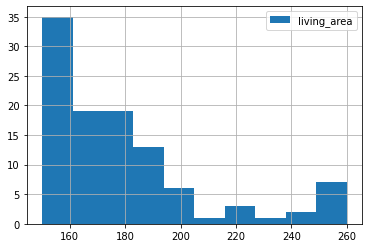

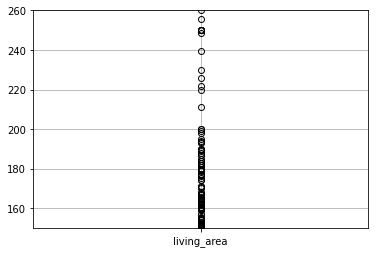

In [25]:
print(df['living_area'].hist(range=(150,260),legend=True));
plt.show()
plt.ylim(150,260)
df.boxplot(column ='living_area');

Обнаружены 2 небольшие группы с аномальными значениями. Это квартиры с жилой площадью до 7.5 м² и больше 200 м². Удалим их.
Ряд объектов имеет жилую площадь больше общей. Объяснения этому нет и случаев мало, поэтому удалим эти строки.

In [26]:
df=df.drop(df[(df['living_area']<7.5)|(df['living_area']>200)].index) #удаляем строки, где жилая площадь < 7.5 м² и больше 200 м²

In [27]:
display(df[df['living_area']>df['total_area']]) #какие случаи будем удалять
df=df.drop(df[df['living_area']>df['total_area']].index)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1595,7,3200000,62.4,2019-04-23,4,NaN,5.0,63.600,2,False,False,False,10.853597,1,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3374,18,3650000,41.5,2018-02-14,3,2.50,5.0,45.000,3,False,False,False,7.218338,0,Санкт-Петербург,12842.0,11005.0,0.0,NaN,1.0,745.0,24.0
8976,5,4350000,41.2,2017-03-17,3,2.50,5.0,45.000,3,False,False,False,7.166157,0,Санкт-Петербург,14918.0,9601.0,0.0,NaN,1.0,694.0,560.0
9795,10,4000000,42.0,2017-11-20,3,2.50,5.0,45.000,3,False,False,False,7.305306,0,Санкт-Петербург,11284.0,12562.0,1.0,358.0,1.0,117.0,276.0
9964,5,3500000,49.5,2018-10-02,4,NaN,5.0,63.600,1,False,False,False,8.609824,0,Санкт-Петербург,11609.0,10539.0,0.0,NaN,1.0,96.0,63.0
11814,1,3490000,42.0,2018-02-12,3,NaN,5.0,45.000,1,False,False,False,7.305306,0,Санкт-Петербург,11605.0,12577.0,0.0,NaN,0.0,NaN,36.0
11977,5,2850000,62.0,2018-07-08,4,2.65,5.0,63.600,1,False,False,False,10.784022,0,Кингисепп,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12040,5,1900000,15.0,2018-06-27,1,2.50,5.0,17.600,1,False,False,False,2.609038,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12129,0,1150000,30.0,2018-08-05,2,2.50,5.0,30.500,2,False,False,False,5.218075,0,поселок городского типа Мга,NaN,NaN,NaN,NaN,NaN,NaN,45.0
12186,1,4900000,71.4,2017-09-21,5,2.60,9.0,91.785,7,False,False,False,12.419019,0,Санкт-Петербург,13592.0,14670.0,1.0,430.0,0.0,NaN,133.0


##### 'ceiling_height'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22590,16,6000000,55.0,2018-10-31,2,1.00,12.0,32.4,7,False,False,False,10.000000,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
5712,5,1500000,42.8,2017-08-14,2,1.20,2.0,27.5,1,False,False,False,5.200000,0,поселок городского типа Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000,40.0,2017-10-17,1,1.75,37.0,17.4,5,False,False,False,8.340000,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
19329,5,1700000,40.0,2018-07-15,2,2.00,9.0,30.5,8,False,False,False,6.957434,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16446,6,12300000,88.3,2019-03-12,3,2.00,5.0,63.9,2,False,False,False,12.000000,0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000,39.0,2017-12-16,1,NaN,9.0,20.0,6,False,False,False,11.000000,2,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23690,3,5500000,52.0,2018-07-19,2,NaN,5.0,31.0,2,False,False,False,6.000000,0,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23692,2,1350000,30.0,2017-07-07,1,NaN,5.0,17.5,4,False,False,False,6.000000,0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000,59.0,2018-01-15,3,NaN,5.0,38.0,4,False,False,False,8.500000,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0


count    14454.000000
mean         2.770460
std          1.262636
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

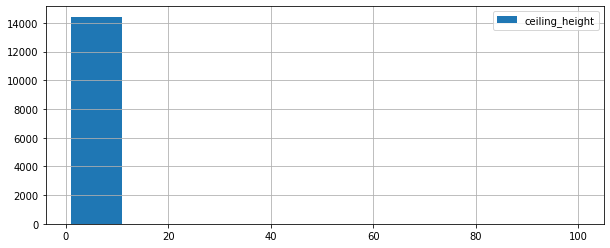

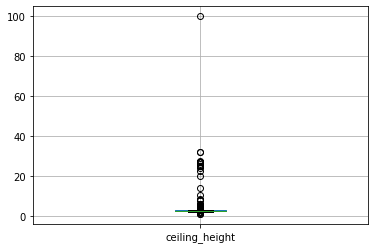

In [28]:
info_column('ceiling_height')

In [29]:
df[df['ceiling_height'].isna()==False].sort_values(by='ceiling_height') #выведем непустые строки, отсортированные по высоте потолков.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22590,16,6000000,55.0,2018-10-31,2,1.00,12.0,32.4,7,False,False,False,10.000000,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
5712,5,1500000,42.8,2017-08-14,2,1.20,2.0,27.5,1,False,False,False,5.200000,0,поселок городского типа Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000,40.0,2017-10-17,1,1.75,37.0,17.4,5,False,False,False,8.340000,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
19329,5,1700000,40.0,2018-07-15,2,2.00,9.0,30.5,8,False,False,False,6.957434,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16446,6,12300000,88.3,2019-03-12,3,2.00,5.0,63.9,2,False,False,False,12.000000,0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4876,7,3000000,25.0,2017-09-27,0,27.00,25.0,17.0,17,False,False,True,4.348396,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
21377,19,4900000,42.0,2017-04-18,1,27.50,24.0,37.7,19,False,False,False,11.000000,2,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
3148,14,2900000,75.0,2018-11-12,3,32.00,3.0,53.0,2,False,False,False,8.000000,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22336,19,9999000,92.4,2019-04-05,2,32.00,6.0,55.5,5,False,False,False,16.500000,4,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN


Настораживает min 5, max 100 и много значений > 3 квартиля. Разобьем гистограмму на 3: 1) высота потолков 2,4-5м.(Стандартная высота потолков 2,6-4м. Сделаем небольшой запас на не совсем стандарт). 2) Меньше стандарта (1-2,3). 3) Больше стандарта (5,1-10).  

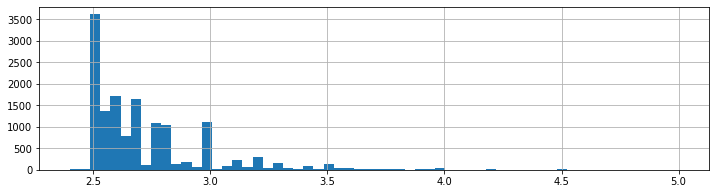

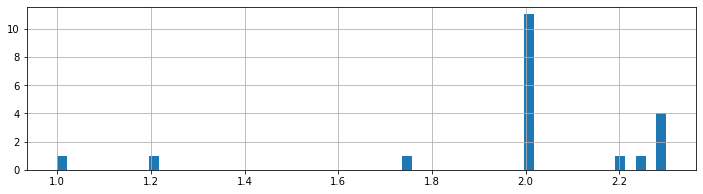

<AxesSubplot:>

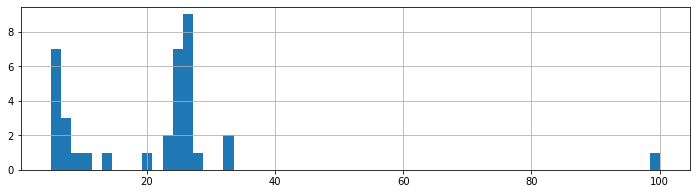

In [30]:

df['ceiling_height'].hist(figsize=(12,3), bins=60, range=(2.4, 5))
plt.show()
df['ceiling_height'].hist(figsize=(12,3), bins=60, range=(1, 2.3))
plt.show()
df['ceiling_height'].hist(figsize=(12,3), bins=60, range=(5.1,100))


В двузначных числах от 24 до 32, скорее всего пропустили десятичный разделитель. Для устранения этого, разделим такие случаи на 10. А остальные(<2.4, от 5.1 до 23, >32) удалим(это всего 35 строк). Заполним пропуски медианой. 

In [31]:
df[df['ceiling_height']>23].sort_values(by='ceiling_height') #в этих строках будем высоту потолков делить на 10.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5076,0,3850000,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,False,False,5.500000,0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,False,False,9.601259,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
4643,0,4300000,45.0,2018-02-01,2,25.0,9.0,30.0,2,False,False,False,7.000000,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
18545,6,3750000,43.0,2019-03-18,2,25.0,5.0,29.0,3,False,False,False,7.479241,0,Санкт-Петербург,27054.0,8033.0,1.0,540.0,0.0,NaN,12.0
6246,6,3300000,44.4,2019-03-25,2,25.0,5.0,31.3,5,False,False,False,5.700000,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN
9379,5,3950000,42.0,2017-03-26,3,25.0,5.0,30.0,2,False,False,False,5.200000,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN
14382,9,1700000,35.0,2015-12-04,1,25.0,5.0,20.0,2,False,False,False,8.000000,1,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,206.0
11285,0,1950000,37.0,2019-03-20,1,25.0,5.0,17.0,4,False,False,False,9.000000,2,Луга,NaN,NaN,NaN,NaN,NaN,NaN,18.0
5669,4,4400000,50.0,2017-08-08,2,26.0,9.0,21.3,3,False,False,False,7.000000,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0
21824,20,2450000,44.0,2019-02-12,2,27.0,2.0,38.0,2,False,False,False,8.600000,2,поселок городского типа Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
checklist = df.query('ceiling_height > 23 and ceiling_height < 33').index # Список для проверки
df.loc[checklist, 'ceiling_height'] = df.loc[checklist, 'ceiling_height'] / 10

In [33]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median()) #Заполним пропуски медианой 

In [34]:
df = df[(df['ceiling_height'] >= 2.4) & (df['ceiling_height'] != 100) & ((df['ceiling_height'] <= 5.1)&(df['ceiling_height'] <=23))]
# удаление строк, где высота потолка <2.4, от 5.1 до 23, >32

##### 'last_price'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,False,False,40.500000,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
17456,7,430000,30.4,2019-04-22,1,2.65,2.0,16.0,1,False,False,False,6.000000,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000,54.0,2018-06-26,2,2.65,3.0,30.5,3,False,False,False,9.392536,0,поселок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16274,18,440000,40.0,2018-07-10,1,2.65,5.0,17.6,1,False,False,False,6.957434,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
5698,7,450000,42.0,2017-07-31,2,2.65,1.0,23.0,1,False,False,False,5.800000,0,поселок городского типа Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19155,20,160000000,243.0,2018-11-12,5,2.65,5.0,145.0,4,False,False,False,33.000000,0,Санкт-Петербург,22640.0,555.0,3.0,285.0,1.0,200.0,18.0
8900,13,190870000,268.0,2016-03-25,3,2.65,8.0,132.0,7,False,False,False,40.000000,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0
16461,17,245000000,285.7,2017-04-10,6,3.35,7.0,182.8,4,False,False,False,29.800000,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0
22831,18,289238400,187.5,2019-03-19,2,3.37,6.0,63.7,6,False,False,False,30.200000,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN


count    2.358700e+04
mean     6.341235e+06
std      7.882537e+06
min      1.219000e+04
25%      3.410500e+06
50%      4.650000e+06
75%      6.760000e+06
max      3.300000e+08
Name: last_price, dtype: float64

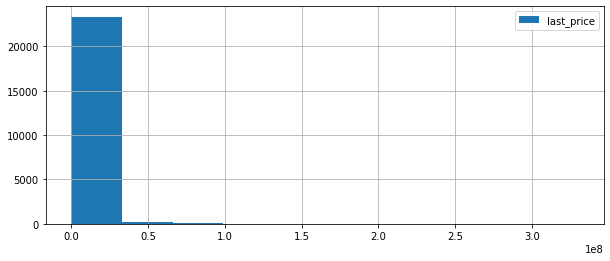

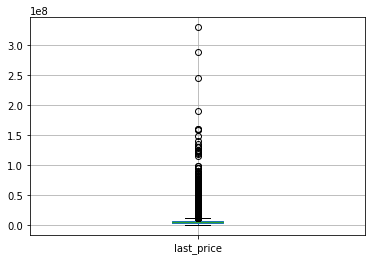

In [35]:
info_column('last_price')

AxesSubplot(0.125,0.125;0.775x0.755)


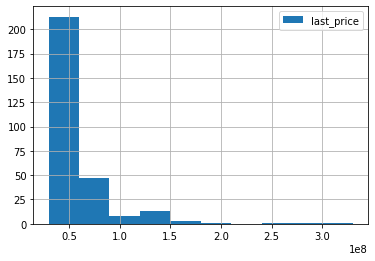

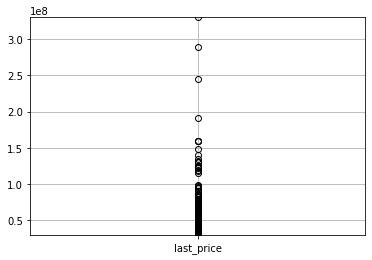

In [36]:
print(df['last_price'].hist(range=(30000000,330000000),legend=True));
plt.show()
plt.ylim(30000000,330000000)
df.boxplot(column ='last_price');

Самая дешевая квартира за 12190 руб. Это невозможно и если не дописали нули, не понятно сколько. Это может стоить и 1 219 000 и 12 190 000. Поэтому просто удалим. Самая дорогая в 330 млн. руб. очень отличается даже от 3 квартиля, который чуть меньше 7 млн.руб. Удалим сильно отличающиеся данные. Все, что дороже 150 млн. руб.

In [37]:
df=df.drop(df[(df['last_price']==12190)|(df['last_price']>150000000)].index)

In [38]:
print('Всего удалено:',old_shape-df.shape[0])
print('Это',old_shape/df.shape[0],'%')

Всего удалено: 120
Это 1.0050892743542983 %


Остальные столбцы не вызывают сомнений.

**Выводы:**
В результате предобработки всего было удалено 120 строк, что около 1% от всех данных.

### Посчитаем и добавим в таблицу новые столбцы

* цена одного квадратного метра;
* день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
* месяц публикации объявления;
* год публикации объявления;
* тип этажа квартиры (значения — «первый», «последний», «другой»);
* расстояние до центра города в километрах (переведите из м в км и округлим до целых значений).

In [39]:
df['price_per_sq'] = (df['last_price'] / df['total_area']).astype('int') #столбец с ценой одного квадратного метра

In [40]:
df['weekday_expos'] = df['first_day_exposition'].dt.weekday #столбец с днем недели

In [41]:
df['month_expos'] = df['first_day_exposition'].dt.month #столбец с месяцем первой публикации

In [42]:
df['year_expos'] = df['first_day_exposition'].dt.year #столбец с годом первой публикации

In [43]:
#создадим функцию, чтобы тип этажа квартиры вывести в отдельный столбец
def floor_type(row):
    floor = row['floor']
    total = row['floors_total']
    
    if floor == 1:
        return 'первый'
    elif floor == total:
        return 'последний'
    else:
        return 'другой'
df['floor_type'] = df.apply(floor_type, axis=1)


In [44]:
#расстояние до центра города в километрах (переведем из м в км и округлим до целых значений).
df['cityCen_near_km'] = ((df['cityCenters_nearest'].fillna(1000000))/1000).round()
df['cityCen_near_km'] = df['cityCen_near_km'].replace(1000,'unknown')
#сначала заполнила пустые ячейки маркером, произвела все операции и изменила маркер на 'unknown'

### Проведем исследовательский анализ данных

#### Изучим следующие параметры объектов:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* этаж квартиры;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего аэропорта;
* расстояние до ближайшего парка;
* день и месяц публикации объявления.

* **общая площадь - `'total_area'`**

count    23579.000000
mean        59.672453
std         31.585394
min         12.000000
25%         40.000000
50%         52.000000
75%         69.600000
max        400.000000
Name: total_area, dtype: float64


<AxesSubplot:>

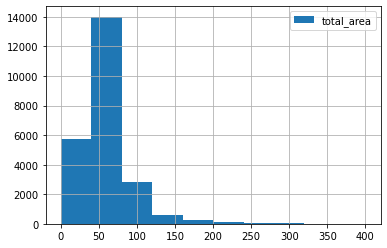

In [45]:
print(df['total_area'].describe())
df['total_area'].hist(range=(0,400),legend=True)

Больше всего квартир с площадью 50-60 м², чуть меньше - около 40 м².

* **жилая площадь - `'living_area'`**

count    23579.000000
mean        33.941876
std         19.727664
min          8.000000
25%         18.400000
50%         30.300000
75%         42.500000
max        200.000000
Name: living_area, dtype: float64


<AxesSubplot:>

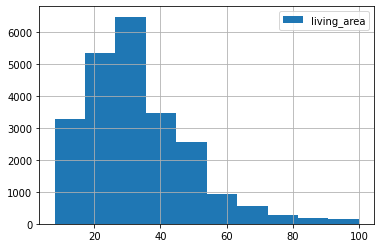

In [46]:
print(df['living_area'].describe())
df['living_area'].hist(range=(8,100),legend=True)

Чаще представлены квартиры с жилой площадью около 30 м², чуть меньше с площадью около 20  м², а с площадью больше 60  м² крайне маленький сегмент.

* **площадь кухни - `'kitchen_area'`**


count    23579.000000
mean        33.941876
std         19.727664
min          8.000000
25%         18.400000
50%         30.300000
75%         42.500000
max        200.000000
Name: living_area, dtype: float64


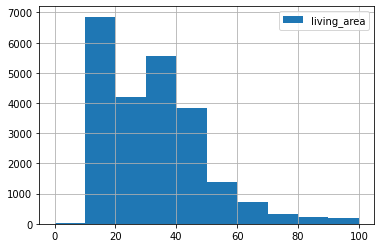

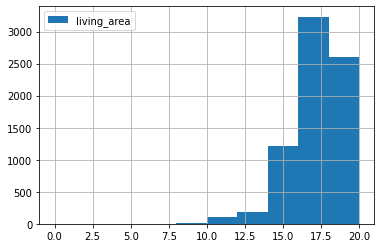

In [47]:
print(df['living_area'].describe())
df['living_area'].hist(range=(0,100),legend=True);
plt.show()
df['living_area'].hist(range=(0,20),legend=True);

Больше всего квартир с кухней до 20 м², а среди них преобладают кухни 17.5 м².

* **цена объекта - `'last_price'`**

count    23579.000000
mean         6.278325
std          6.889245
min          0.430000
25%          3.407000
50%          4.650000
75%          6.750000
max        148.000000
Name: last_price, dtype: float64


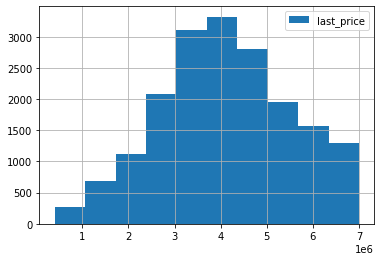

In [48]:
print((df['last_price']/1000000).describe())
df['last_price'].hist(range=(400000,7000000),legend=True);

In [49]:
df.sort_values(by='last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq,weekday_expos,month_expos,year_expos,floor_type,cityCen_near_km
14911,5,430000,54.0,2018-06-26,2,2.65,3.0,30.500,3,False,False,False,9.392536,0,поселок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0,7962,1,6,2018,последний,unknown
17456,7,430000,30.4,2019-04-22,1,2.65,2.0,16.000,1,False,False,False,6.000000,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14144,0,4,2019,первый,unknown
16274,18,440000,40.0,2018-07-10,1,2.65,5.0,17.600,1,False,False,False,6.957434,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,11000,1,7,2018,первый,unknown
5698,7,450000,42.0,2017-07-31,2,2.65,1.0,23.000,1,False,False,False,5.800000,0,поселок городского типа Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0,10714,0,7,2017,первый,unknown
9581,7,450000,43.4,2018-08-31,2,2.65,5.0,30.300,3,False,False,False,5.500000,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0,10368,4,8,2018,другой,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,9,130278280,304.0,2015-07-24,5,3.11,9.0,91.785,7,False,False,False,52.876497,0,Санкт-Петербург,25593.0,5913.0,2.0,164.0,0.0,NaN,599.0,428546,4,7,2015,другой,6.0
7674,20,131000000,380.0,2016-09-23,5,3.90,6.0,150.000,4,False,False,False,66.095622,1,Санкт-Петербург,25801.0,4504.0,2.0,161.0,1.0,635.0,901.0,344736,4,9,2016,другой,5.0
17912,17,135000000,166.0,2019-02-07,3,3.30,7.0,52.000,1,False,False,False,64.000000,0,Санкт-Петербург,32863.0,5955.0,2.0,230.0,3.0,215.0,NaN,813253,3,2,2019,первый,6.0
12674,16,140000000,241.0,2015-07-24,5,3.00,5.0,91.785,4,False,False,False,41.918539,0,Санкт-Петербург,23512.0,3503.0,3.0,413.0,3.0,83.0,399.0,580912,4,7,2015,другой,4.0


Самая дешевая квартира, представленная на рынке, стоит 430 000 руб. Самая дорогая - 148 млн.руб. Больше всего представлено объектов стоимостью около 4.5 - 5 млн.руб.

* **количество комнат - `'rooms'`**

count    23579.00000
mean         2.06069
std          1.05015
min          0.00000
25%          1.00000
50%          2.00000
75%          3.00000
max         16.00000
Name: rooms, dtype: float64
1     8024
2     7926
3     5794
4     1161
5      315
0      194
6       98
7       44
8       10
9        6
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64


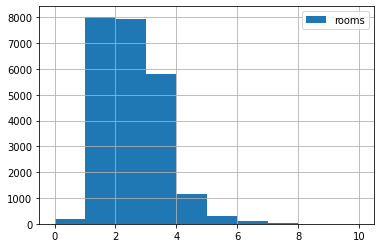

In [50]:
print(df['rooms'].describe())
print(df['rooms'].value_counts())
df['rooms'].hist(range=(0,10),legend=True);

In [51]:
df.sort_values(by='rooms')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq,weekday_expos,month_expos,year_expos,floor_type,cityCen_near_km
10008,20,5050000,44.2,2017-09-14,0,2.70,9.0,32.2,1,False,True,False,0.000000,0,Санкт-Петербург,24329.0,5955.0,0.0,NaN,2.0,520.0,69.0,114253,3,9,2017,первый,6.0
3019,18,2100000,24.0,2017-11-10,0,2.65,10.0,18.0,6,False,False,True,4.174460,2,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,5.0,87500,4,11,2017,другой,unknown
2532,5,3500000,27.1,2018-02-01,0,2.65,18.0,18.7,9,False,False,True,4.713661,2,Санкт-Петербург,32036.0,8175.0,0.0,NaN,1.0,644.0,70.0,129151,3,2,2018,другой,8.0
22877,2,4280000,28.0,2017-10-26,0,2.70,19.0,18.0,10,False,True,False,0.000000,0,Санкт-Петербург,18982.0,7206.0,0.0,NaN,1.0,415.0,151.0,152857,3,10,2017,другой,7.0
6408,0,2450000,27.0,2017-11-07,0,2.65,23.0,14.0,22,False,True,False,0.000000,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0,90740,1,11,2017,другой,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18891,11,40000000,290.0,2016-06-21,10,3.50,6.0,189.4,6,False,False,False,30.000000,1,Санкт-Петербург,26229.0,4932.0,3.0,316.0,1.0,227.0,77.0,137931,1,6,2016,последний,5.0
648,3,17500000,183.7,2018-07-01,11,3.40,7.0,138.8,7,False,False,False,13.300000,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN,95264,6,7,2018,последний,3.0
9688,8,33000000,194.1,2017-02-07,11,3.43,5.0,129.0,2,False,False,False,11.900000,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0,170015,1,2,2017,другой,1.0
20829,6,28659000,245.4,2016-03-31,14,2.65,4.0,168.3,2,False,False,False,25.900000,0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0,116784,3,3,2016,другой,2.0


In [52]:
df[df['studio']== True] #только студии. Чтобы убедиться, что количество комнат указано 0.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq,weekday_expos,month_expos,year_expos,floor_type,cityCen_near_km
144,1,2450000,27.00,2017-03-30,0,2.65,24.0,15.50,2,False,True,False,0.0,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,90740,3,3,2017,другой,unknown
440,8,2480000,27.11,2018-03-12,0,2.65,17.0,24.75,4,False,True,False,0.0,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,91479,0,3,2018,другой,15.0
608,2,1850000,25.00,2019-02-20,0,2.65,10.0,18.00,7,False,True,False,0.0,0,поселок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,74000,2,2,2019,другой,unknown
697,12,2500000,24.10,2017-12-01,0,2.75,25.0,17.50,21,False,True,False,0.0,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0,103734,4,12,2017,другой,unknown
716,5,1500000,17.00,2017-06-07,0,2.70,9.0,12.00,1,False,True,False,0.0,0,поселок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0,88235,2,6,2017,первый,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22867,8,3090000,30.00,2017-12-17,0,2.65,25.0,18.20,5,False,True,False,0.0,0,Санкт-Петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,211.0,103000,6,12,2017,другой,16.0
22877,2,4280000,28.00,2017-10-26,0,2.70,19.0,18.00,10,False,True,False,0.0,0,Санкт-Петербург,18982.0,7206.0,0.0,NaN,1.0,415.0,151.0,152857,3,10,2017,другой,7.0
23210,7,3200000,26.00,2017-09-01,0,2.65,25.0,18.00,16,False,True,False,0.0,0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,123076,4,9,2017,другой,13.0
23554,15,3350000,26.00,2018-09-07,0,2.65,19.0,18.00,8,False,True,False,0.0,0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,128846,4,9,2018,другой,17.0


Примерно одинаковое количество 1-комнатных и 2-х комнатных. Они занимают 70% рынка. Есть квартиры с 0 комнат, так указали студии.

* **высота потолков - `'ceiling_height'`**

count    23579.000000
mean         2.695656
std          0.212788
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64


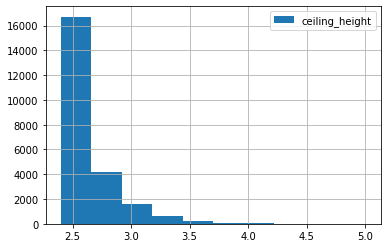

In [53]:
print(df['ceiling_height'].describe())
df['ceiling_height'].hist(range=(2.4,5),legend=True);

После нашей предобработки, средняя высота потолков 2.65м

* **этаж квартиры - `'floor'`, общее количество этажей в доме  `'floors_total'` и тип этажа квартиры («первый», «последний», «другой») `'floor_type'`**

count    23579.000000
mean         5.894694
std          4.885036
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


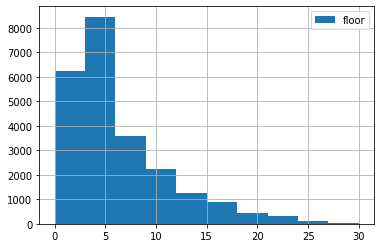

In [54]:
print(df['floor'].describe())
df['floor'].hist(range=(0,30),legend=True);

count    23493.000000
mean        10.686587
std          6.597935
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


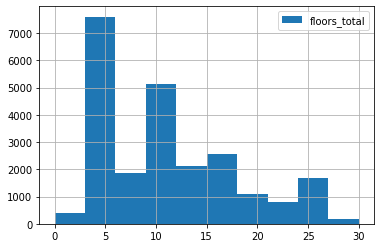

In [55]:
print(df['floors_total'].describe())
df['floors_total'].hist(range=(0,30),legend=True);

другой       17379
последний     3304
первый        2896
Name: floor_type, dtype: int64


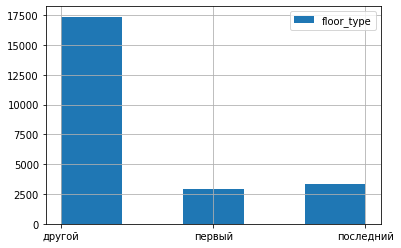

In [56]:
print(df['floor_type'].value_counts())
df['floor_type'].hist(bins=5,legend=True);

Больше всего квартир представлено на 4-5 этажах. Выше 5 этажа встречается реже, чем до 4 этажа. Этажность домов идет пиками. Все верно, у нас много типого строительства: большие серии пятиэтажных, девятиэтажных, двенадцатиэтажных домов. Последних этажей представлено чуть больше, чем первых. И каждого из них примерно в 5 раз меньше, чем остальных.

* **расстояние до центра города в метрах - `'cityCenters_nearest'`, расстояние до ближайшего аэропорта - `'airports_nearest'` и расстояние до ближайшего парка `'parks_nearest'`**

count    18089.000000
mean     14220.153519
std       8610.491371
min        181.000000
25%       9277.000000
50%      13118.000000
75%      16306.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


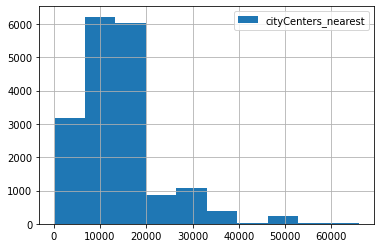

In [57]:
print(df['cityCenters_nearest'].describe())
df['cityCenters_nearest'].hist(legend=True);

count    18068.000000
mean     28810.190779
std      12645.123800
min          0.000000
25%      18575.750000
50%      26757.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64


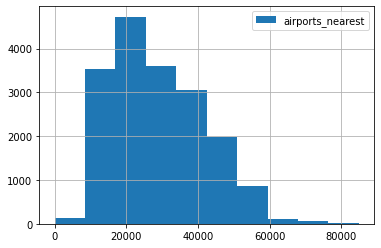

In [58]:
print(df['airports_nearest'].describe())
df['airports_nearest'].hist(legend=True);

count    8022.000000
mean      491.166916
std       343.020699
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


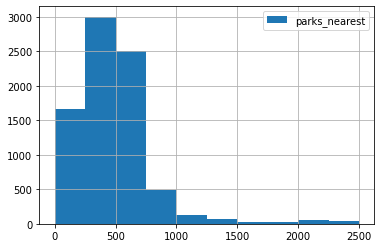

In [59]:
print(df['parks_nearest'].describe())
df['parks_nearest'].hist(range=(0,2500),legend=True);

Большинство кварир находятся на расстоянии 9-20 км. от центра города, от аэропорта в 18-30 км. Аэропорт в Санкт-Петербурге находится как раз в 20 км от центра города, а большинство квартир продается в Санкт-Петербурге. В половине квартир рядом парк(300-600м).

* **день публикации объявления - `'weekday_expos'` и месяц публикации объявления - `'month_expos'`**

3    4273
1    4164
4    3987
2    3954
0    3590
5    1925
6    1686
Name: weekday_expos, dtype: int64


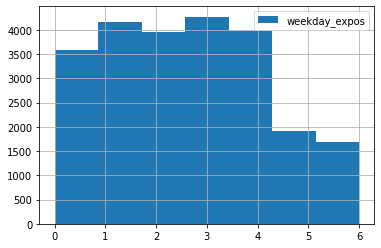

In [60]:
print(df['weekday_expos'].value_counts())
df['weekday_expos'].hist(bins=7,legend=True);

2     2625
3     2574
4     2368
11    2364
10    2114
9     1975
6     1752
8     1737
7     1685
12    1630
1     1488
5     1267
Name: month_expos, dtype: int64


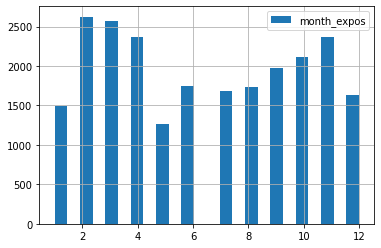

In [61]:
print(df['month_expos'].value_counts())
df['month_expos'].hist(bins=24,legend=True);

Меньше всего объявлений было опубликовано в выходные дни. Так же меньше было в декабре, январе и мае. Скорее всего это связано с длительными праздничными выходными в эти месяцы.

**Выводы:**
Больше всего на рынке представлено 1-комнатных и 2-комнатных квартир. Они занимают 70% рынка. Чаще встречаются квартиры с общей площадью 50-60 м² и около 30 м² жилой. Самая дешевая квартира, представленная на рынке, стоит 430 000 руб. Самая дорогая - 148 млн.руб. Больше всего представлено объектов стоимостью около 4.5-5 млн.руб. Чаще на 4-5 этажах. Выше 5 этажа встречается реже, чем до 4 этажа. Этажность домов идет пиками. Все верно, у нас много типого строительства: большие серии пятиэтажных, девятиэтажных, двенадцатиэтажных домов. Последних этажей представлено чуть больше, чем первых. И каждого из них примерно в 5 раз меньше, чем остальных. Большинство объектов находятся на расстоянии 9-20 км. от центра города. В половине квартир рядом парк(300-600м).

#### Быстрота продаж квартир - `'days_exposition'`

count    20413.000000
mean       180.934160
std        219.771211
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


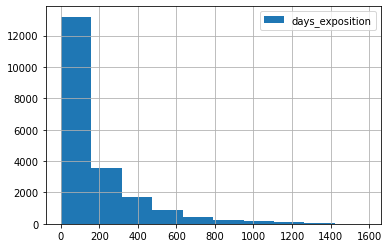

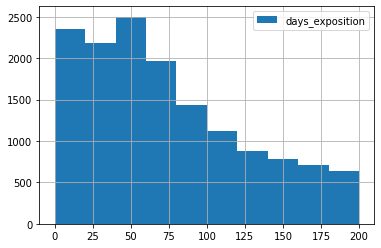

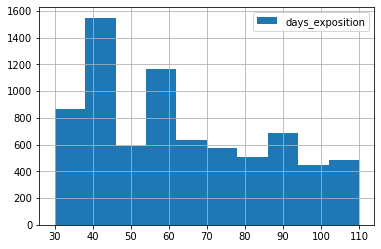

In [62]:
print(df['days_exposition'].describe())
df['days_exposition'].hist(legend=True)
plt.show()
df['days_exposition'].hist(range=(0,200),legend=True);
plt.show()
df['days_exposition'].hist(range=(30,110),legend=True);

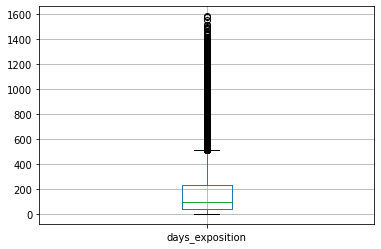

In [63]:
df.boxplot(column = 'days_exposition');

**Выводы:**
Среднее время продажи квартир 169 дней, медианное - 95. Такое расхождение из-за большого разброса дней продажи. Большинство квартир продаются в районе 90-100 дней. Есть и квартиры, которые продавались за 1 день, но все же все продажи до 45 дней можно считать быстрыми. Их 25% рынка. Максимальное время продажи - 1580 дней. И все продажи квартир более 400 дней - необычно долгие. Есть всплески в районе 1.5 месяца, 2 и 3 месяца. Всплески явные, если даже предположить, что какие-то квартиры не проданы,а просто сняты с продажи, объяснение этому не могу найти.

#### Факторы, влияющие на общую (полную) стоимость объекта

##### Зависимость цены от общей площади

Корелляция цены от общей площади 0.7378662293841048


<AxesSubplot:xlabel='last_price', ylabel='total_area'>

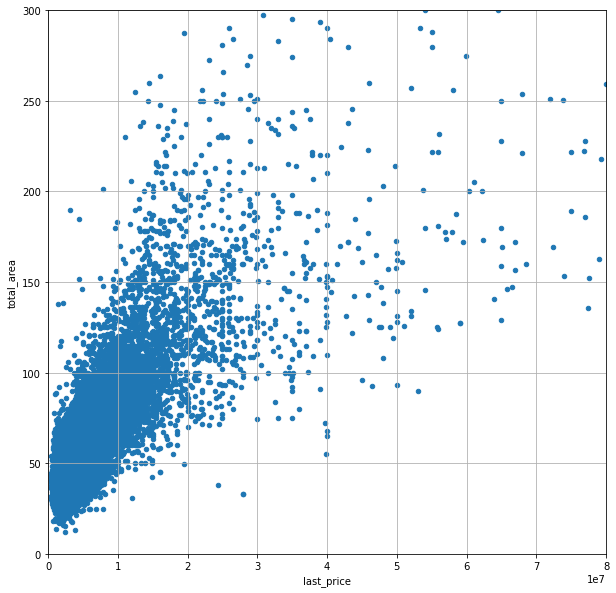

In [64]:
print('Корелляция цены от общей площади',df['last_price'].corr(df['total_area']))

df.plot(x='last_price',y='total_area',kind='scatter', grid=True, figsize=(10,10),xlim=(0,80000000),ylim=(0,300))

Цена зависит от размера общей площади.

##### Зависимость цены от жилой площади

Корелляция цены от жилой площади 0.6207080512925627


<AxesSubplot:xlabel='last_price', ylabel='living_area'>

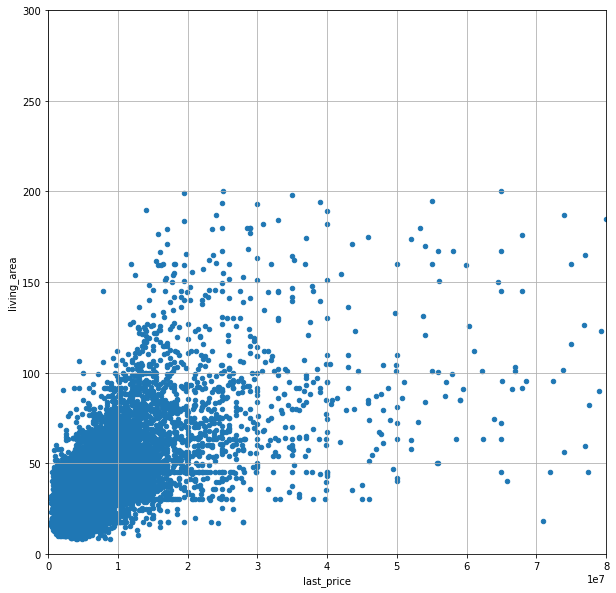

In [65]:
print('Корелляция цены от жилой площади',df['last_price'].corr(df['living_area']))

df.plot(x='last_price',y='living_area',kind='scatter', grid=True, figsize=(10,10),xlim=(0,80000000),ylim=(0,300))

Зависимость цены от жилой площади чуть меньше, чем от общей, но тем не менее ярко прослеживается.

##### Зависимость цены от площади кухни

Корелляция цены от площади кухни 0.5930829675513032


<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

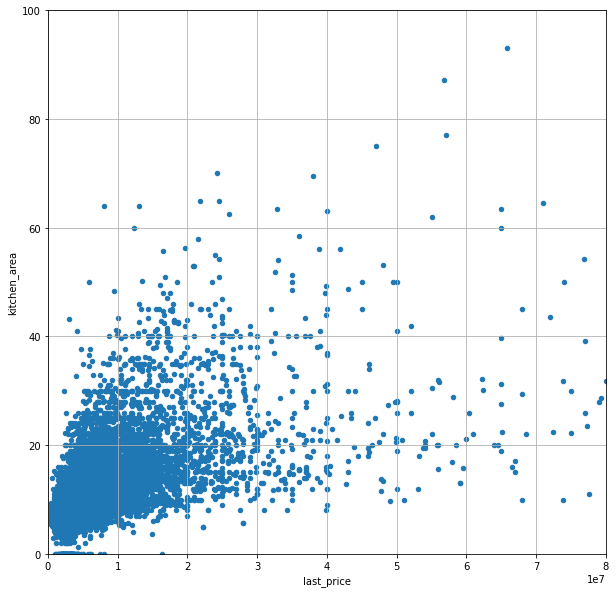

In [66]:
print('Корелляция цены от площади кухни',df['last_price'].corr(df['kitchen_area']))

df.plot(x='last_price',y='kitchen_area',kind='scatter', grid=True, figsize=(10,10),xlim=(0,80000000),ylim=(0,100))

Цена квартиры зависит от площади кухни в той же мере, что и от жилой площади.

##### Зависимость цены от количества комнат

Корелляция цены от количества комнат 0.4424800960226561


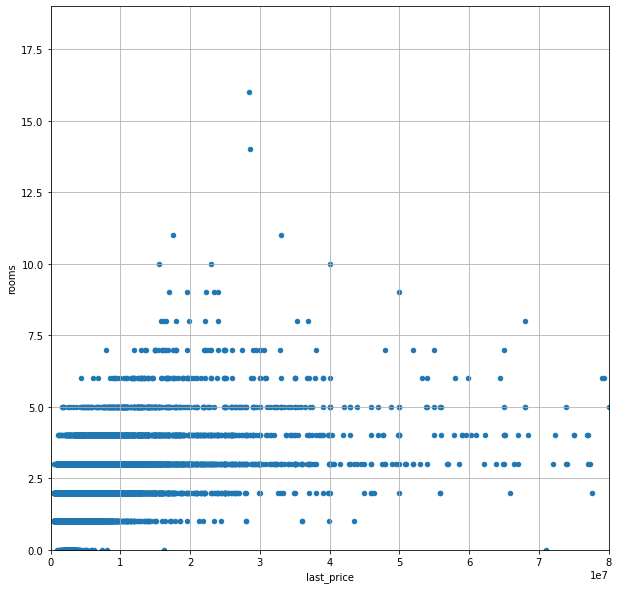

In [67]:
print('Корелляция цены от количества комнат',df['last_price'].corr(df['rooms']))

df.plot(x='last_price',y='rooms',kind='scatter', grid=True, figsize=(10,10),xlim=(0,80000000),ylim=(0,19));

rooms
0      2715000
1      3600000
2      4772669
3      6200000
4      9000000
5     13800000
6     18075000
8     21045000
7     22320000
9     22875000
10    23000000
11    25250000
16    28500000
14    28659000
Name: last_price, dtype: int64


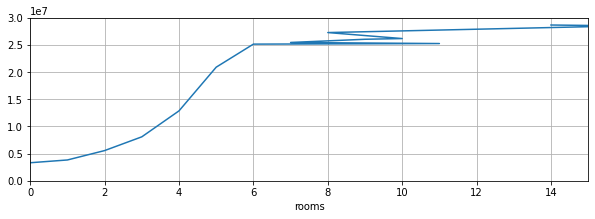

In [68]:
print(df.groupby('rooms')['last_price'].median().sort_values())
(df.groupby('rooms')['last_price'].mean().sort_values()).plot(figsize=(10,3),ylim=(0,30000000),xlim=(0,15),grid=True);


Если смотреть корелляцию на всех данных, зависимость общей стоимости квартиры от количества комнат очень незначительная, но если сгруппировать объекты по количеству комнат и посмотреть  медианное значения цены в каждой группе, видим четкую зависимость цены от количества комнат в квартирах с количеством комнат до 5 и с ценой до 25 млн.руб. В квартирах с большим количеством комнат и с большей ценой, зависимость очень-очень слабая. 

##### Зависимость цены от этажа, на котором расположена квартира (первый, последний, другой)

floor_type
первый       3900000
последний    4300000
другой       4850000
Name: last_price, dtype: int64


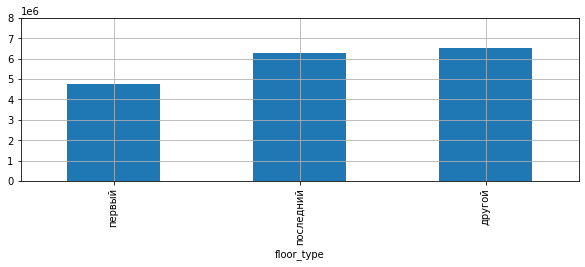

In [69]:
print(df.groupby('floor_type')['last_price'].median().sort_values())
(df.groupby('floor_type')['last_price'].mean().sort_values()).plot(figsize=(10,3),ylim=(0,8000000),xlim=(0,3),grid=True,kind='bar');

Зависимость цены от этажа тоже есть. Дешевле всего первый этаж. И, как ни странно, последний этаж дороже всех остальных.

##### Зависимость цены от даты размещения (день недели, месяц, год)

               last_price
weekday_expos            
5                 4550000
6                 4550000
4                 4580000
0                 4650000
3                 4650000
1                 4700000
2                 4700000


<AxesSubplot:xlabel='weekday_expos'>

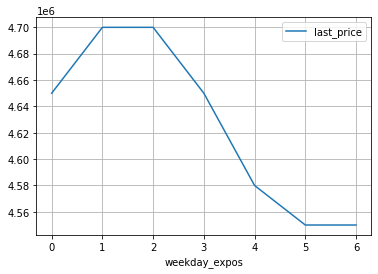

In [70]:
print(df.pivot_table(index = 'weekday_expos', values = 'last_price', aggfunc='median').sort_values(by='last_price'))
(df.pivot_table(index = 'weekday_expos', values = 'last_price',aggfunc='median').plot(grid=True))


             last_price
month_expos            
6               4400000
5               4500000
10              4550000
8               4570000
1               4600000
2               4650000
3               4650000
7               4650000
9               4699000
11              4700000
12              4700000
4               4800000


<AxesSubplot:xlabel='month_expos'>

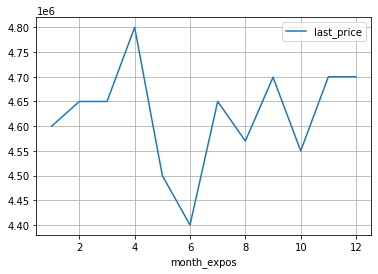

In [71]:
print(df.pivot_table(index = 'month_expos', values = 'last_price', aggfunc='median').sort_values(by='last_price'))
(df.pivot_table(index = 'month_expos', values = 'last_price',aggfunc='median').plot(grid=True))



            last_price
year_expos            
2017           4500000
2016           4550000
2018           4570000
2019           5050000
2015           5300500
2014           7700000


<AxesSubplot:xlabel='year_expos'>

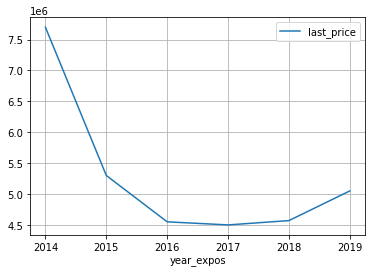

In [72]:
print(df.pivot_table(index = 'year_expos', values = 'last_price', aggfunc='median').sort_values(by='last_price'))
(df.pivot_table(index = 'year_expos', values = 'last_price',aggfunc='median').plot(grid=True))


Графики показали зависимость цены от дня недели. Самая высокая в начале недели и к концу постепенно падает. Возможно многие подают объявление в начале недели и если быстро не продается, опускают цену. Так же есть зависимость и от месяца продажи, дешевле продаются в мая и июне, а дороже в апреле, ноябре и декабре. Такая зависимость связана с сезонностью, в конце весны и летом многие уезжают на дачи, в отпуска и откладывают продажи до возвращения. От года тоже зависит цена продажи. Так 2014 были максимальные цены, к 2016 году значительно упали, а в 2018 начали потихоньку подниматься. Это объясняется экономическим кризисом в 2014 году, когда цены на недвижимость упали по всей стране.

**Выводы:**
Все рассмотренные факторы влияют на общую стоимость объекта в большей или меньшей степени. Больше всего цена зависит от размеров общей и жилой площади. Так же прослеживается явная зависимость цены от количества комнат в квартирах с количеством комнат до 5 и с ценой до 25 млн.руб. В квартирах с большим количеством комнат и с большей ценой, зависимость очень-очень слабая. Дешевле всего первые этажи. Не так сильно, но зависит цена и от месяца и года продажи.На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшую стоимость недвижимости. Меньше спрос из-за отпусков, цена дешевеет.

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [73]:
mean_price_per_sq = df.pivot_table(index = 'locality_name', values = 'price_per_sq',aggfunc = ['mean','count'])
mean_price_per_sq.columns = ['mean_price_per_sq', 'count']
mean_price_per_sq = mean_price_per_sq.sort_values(by='count',ascending=False).head(10)
display(mean_price_per_sq)

print('Cамая высокая стоимость квадратного метра:')
display(mean_price_per_sq.loc[mean_price_per_sq['mean_price_per_sq']==mean_price_per_sq['mean_price_per_sq'].max()]) #самая высокая стоимость
print('Cамая низкая стоимость квадратного метра:')
mean_price_per_sq[mean_price_per_sq['mean_price_per_sq']==mean_price_per_sq['mean_price_per_sq'].min()] #самая низкая стоимость

,mean_price_per_sq,count
locality_name,,
Санкт-Петербург,113965.003966,15632
поселок Мурино,85653.156757,555
поселок Шушары,78676.904545,440
Всеволожск,68788.739241,395
Пушкин,103100.445652,368
Колпино,75424.150888,338
поселок Парголово,90175.489297,327
Гатчина,68745.693811,307
деревня Кудрово,92473.086957,299


Cамая высокая стоимость квадратного метра:


,mean_price_per_sq,count
locality_name,,
Санкт-Петербург,113965.003966,15632


Cамая низкая стоимость квадратного метра:


,mean_price_per_sq,count
locality_name,,
Выборг,58237.723404,235


####  Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра. Опишем, как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:xlabel='cityCen_near_km'>

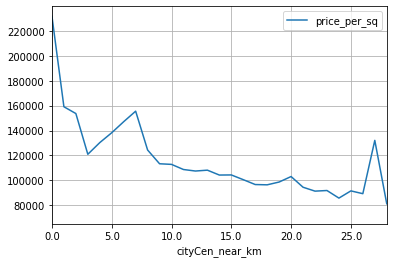

In [74]:
mean_price_km = df[df['locality_name']=='Санкт-Петербург']
mean_price_km = mean_price_km.pivot_table(index = 'cityCen_near_km', values = 'price_per_sq', aggfunc = 'mean')
mean_price_km.plot(xlim =(0,28),grid=True)


Чем ближе к центру города, тем стоимость объектов возрастает. Есть небольшой всплеск в районе 7 км от центра, возможно, там дорогой жк бизнес-класса, где цена м² высокая. Так же есть всплеск около 27 км от центра. Это уже пригород, возможно, там какой-либо крупный населенный пункт, где цена выше.

### Общий вывод:
Больше всего на рынке представлено 1-комнатных и 2-комнатных квартир. Они занимают 70% рынка.Чаще встречаются квартиры с общей площадью 50-60 м² и около 30 м² жилой. Самая дешевая квартира, представленная на рынке, стоит 430 000 руб. Самая дорогая - 148 млн.руб. Больше всего представлено объектов стоимостью около 4.5 - 5 млн.руб. Чаще на 4-5 этажах. Выше 5 этажа встречается реже, чем до 4 этажа. Этажность домов идет пиками. Все верно, у нас много типого строительства: большие серии пятиэтажных, девятиэтажных, двенадцатиэтажных домов. Последних этажей представлено чуть больше, чем первых. И каждого из них примерно в 5 раз меньше, чем остальных. Большинство объектов находятся на расстоянии 9-20 км. от центра города. В половине квартир рядом парк(300-600м).

Среднее время продажи квартир 169 дней, медианное - 95. Такое расхождение из-за большого разброса дней продажи. Большинство квартир продаются в районе 90-100 дней. Есть и квартиры, которые продавались за 1 день, но все же все продажи до 45 дней можно считать быстрыми. Их 25% рынка. Максимальное время продажи - 1580 дней. И все продажи квартир более 400 дней - необычно долгие.

Больше всего цена квартир зависит от размеров общей и жилой площади. Так же прослеживается явная зависимость цены от количества комнат в квартирах с количеством комнат до 5 и с ценой до 25 млн.руб. В квартирах с большим количеством комнат и с большей ценой, зависимость очень-очень слабая. Дешевле всего первые этажи. И, как ни странно, последний этаж дороже всех остальных. Не так сильно, но зависит цена и от месяца и года продажи.На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшую стоимость недвижимости. Меньше спрос из-за отпусков, цена дешевеет.

Подавляющее большинство квартир продается в Санкт-Петербурге - 15676, а цена около 115000 руб/м². Помимо Санкт-Петербурга в Топ10 по количеству продаж входят: поселок Мурино, поселок Шушары, Всеволожск, Пушкин. Чем ближе к центру города, тем стоимость объектов возрастает. Есть небольшой всплеск в районе 7 км от центра, возможно, там дорогой жк бизнес-класса, где цена м² высокая. Так же есть всплеск около 27 км от центра. Это уже пригород, возможно, там какой-либо крупный населенный пункт, где цена выше, чем в небольших.
